# Setup

### Run this cell only one time (For installation of required packages)

In [1]:
pip install -r required_packages.txt

### Run this cell only one time (Requires human intevention for one time download of NLTK data)

In [2]:
# Run this is only one time as it will download nltk data and will not require downloading again

import nltk
nltk.download()  # This will open a pop-up window for installation of NLTK data in few seconds (follow the steps in the installation window)

In [1]:
# Gereral
import os

import numpy as np
import pandas as pd
import datetime as dt
import time
import copy
import pickle
import warnings
warnings.simplefilter("ignore")

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud

# NLP
import re
import nltk

from nltk.corpus import stopwords
from nltk.tag import pos_tag
from spello.model import SpellCorrectionModel
from langdetect import detect, detect_langs

# ML
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced


from transformers import AutoTokenizer, TFAutoModel

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Input #, InputLayer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# For pre-trained word2vec & cosine similarity calculation
from gensim.models import KeyedVectors
from numpy.linalg import norm



# Load Data

In [2]:
os.getcwd()

'C:\\Users\\AbhinavSaxenaAdaptfy\\Downloads\\Testing\\Codebase'

In [3]:
train_path = os.path.join("Input Data","train.csv")
test_path = os.path.join("Input Data","test.csv")

In [4]:
# Load data
def load_data():
    data_train = pd.read_csv(filepath_or_buffer = train_path, sep = ",", header = 0)
    data_test = pd.read_csv(filepath_or_buffer = test_path, sep = ",", header = 0)
    return data_train, data_test

In [5]:
data_train, data_test = load_data()

# EDA (Before Data Cleaning)

##### Let's look at the structure of the data

In [6]:
#pd.set_option('display.max_columns', 81)
data_train.head()

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93686 entries, 0 to 93685
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            93686 non-null  object
 1   sub_category        87095 non-null  object
 2   crimeaditionalinfo  93665 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


In [8]:
data_train.describe()

,category,sub_category,crimeaditionalinfo
count,93686,87095,93665
unique,15,35,85013
top,Online Financial Fraud,UPI Related Frauds,Respected Sir\r\n\r\nA very serious matter I w...
freq,57434,26856,2342


##### Let's look at the distribution of the crime reports

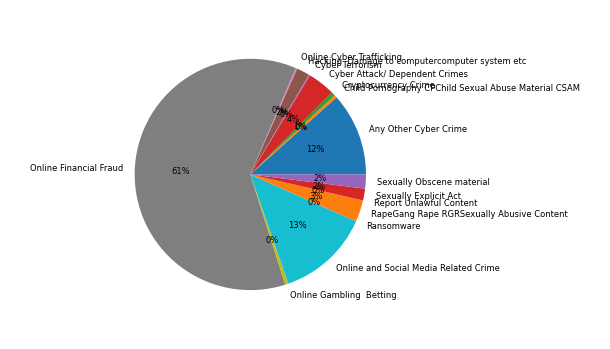

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, tight_layout=True, dpi = 300)

data_train.groupby(['category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))

plt.show()

In [10]:
data_train['category'].value_counts()

category
Online Financial Fraud                                  57434
Online and Social Media Related Crime                   12140
Any Other Cyber Crime                                   10878
Cyber Attack/ Dependent Crimes                           3608
RapeGang Rape RGRSexually Abusive Content                2822
Sexually Obscene material                                1838
Hacking  Damage to computercomputer system etc           1710
Sexually Explicit Act                                    1552
Cryptocurrency Crime                                      480
Online Gambling  Betting                                  444
Child Pornography CPChild Sexual Abuse Material CSAM      379
Online Cyber Trafficking                                  183
Cyber Terrorism                                           161
Ransomware                                                 56
Report Unlawful Content                                     1
Name: count, dtype: int64

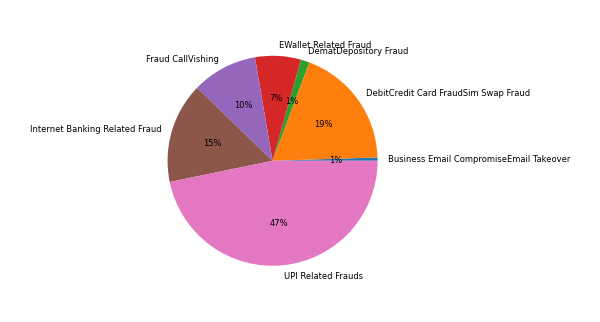

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, tight_layout=True, dpi = 300)

data_train.query('category=="Online Financial Fraud"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))
#data_train.query('category=="Online and Social Media Related Crime"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))
#data_train.query('category=="Cyber Attack/ Dependent Crimes"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))

plt.show()

In [12]:
data_train['sub_category'].value_counts()

sub_category
UPI Related Frauds                                                      26856
Other                                                                   10878
DebitCredit Card FraudSim Swap Fraud                                    10805
Internet Banking Related Fraud                                           8872
Fraud CallVishing                                                        5803
Cyber Bullying  Stalking  Sexting                                        4089
EWallet Related Fraud                                                    4047
FakeImpersonating Profile                                                2299
Profile Hacking Identity Theft                                           2073
Cheating by Impersonation                                                1988
Unauthorised AccessData Breach                                           1114
Online Job Fraud                                                          912
DematDepository Fraud                              

In [13]:
data_train.groupby(by = ["category","sub_category"], dropna=False).agg(report_count = ("crimeaditionalinfo", "size"))

report_count
category                                           sub_category                                                    
Any Other Cyber Crime                              Other                                                      10878
Child Pornography CPChild Sexual Abuse Material... NaN                                                          379
Cryptocurrency Crime                               Cryptocurrency Fraud                                         480
Cyber Attack/ Dependent Crimes                     Data Breach/Theft                                            484
                                                   Denial of Service (DoS)/Distributed Denial of S...           504
                                                   Hacking/Defacement                                           540
                                                   Malware Attack                                               521
                                                   Ransomware Attack                                            534
                                                   SQL Injection                                                508
                                                   Tampering with computer source documents                     517
Cyber Terrorism                                    Cyber Terrorism                                              161
Hacking  Damage to computercomputer system etc     Damage to computer computer systems etc                      108
                                                   Email Hacking                                                349
                                                   Tampering with computer source documents                      50
                                                   Unauthorised AccessData Breach                              1114
                                                   Website DefacementHacking                                     89
Online Cyber Trafficking                           Online Trafficking                                           183
Online Financial Fraud                             Business Email CompromiseEmail Takeover                      290
                                                   DebitCredit Card FraudSim Swap Fraud                       10805
                                                   DematDepository Fraud                                        761
                                                   EWallet Related Fraud                                       4047
                                                   Fraud CallVishing                                           5803
                                                   Internet Banking Related Fraud                              8872
                                                   UPI Related Frauds                                         26856
Online Gambling  Betting                           Online Gambling  Betting                                     444
Online and Social Media Related Crime              Cheating by Impersonation                                   1988
                                                   Cyber Bullying  Stalking  Sexting                           4089
                                                   EMail Phishing                                               157
                                                   FakeImpersonating Profile                                   2299
                                                   Impersonating Email                                           44
                                                   Intimidating Email                                            29
                                                   Online Job Fraud                                             912
                                                   Online Matrimonial Fraud                                     132
                                           

# Data Cleaning

In [2]:
# Define function for punctuation removal

def remove_punctuations(text):

    # Replace ' with '' without space so that eg: don't gets replaced as dont 
    no_punct_output = text.replace("'", "")

    # create a translation table (replacing all punctuations with space so that eg: <I am good.Thank you> becomes <I am good Thank you>)
    no_punct_output = re.sub('[^a-zA-Z0-9\s]+', ' ', text)
    
    return no_punct_output

In [8]:
# CLEANING

def clean_data(df_input_data):

    '''
    Returns a dataframe with clean data.
    Convert reports to lower case, remove whitespaces, remove punctuations, remove duplicates, give names to blank category / sub-category values.

            Parameters:
                    df_input: dataframe 
                        Raw input data

            Returns:
                    df_output: dataframe
                        Dataframe with clean data
    '''
    
    start = time.time()
    
    df_output_data = df_input_data
    
    df_output_data = df_output_data.rename(columns = {'crimeaditionalinfo' : 'reports'}) # Rename 'crimeaditionalinfo' column to 'reports'

    # Remove whitespaces and punctuations from text
    
    df_output_data.reports = df_output_data.reports.astype(str).str.strip() # Removing leading & trailing whitespaces from reports text entry
    df_output_data.reports = df_output_data.reports.str.lower() # Change text of reports to lowercase
    df_output_data.reports = df_output_data.reports.apply(lambda x: remove_punctuations(str(x))) # Remove punctuations from report text

    # Replace one / multiple whitespaces between words with single space
    for i in range(len(df_output_data['reports'])):
        df_output_data.loc[i,'reports'] = ' '.join(df_output_data.loc[i,'reports'].split())
    
    df_output_data = df_output_data.dropna(subset = ["reports"]) # Remove entries with NA report
    df_output_data.reports = df_output_data.reports.astype(str).str.strip() # Removing leading & trailing whitespaces from reports text entry
    df_output_data = df_output_data[df_output_data["reports"] != ''] # Remove entries with blank report
    df_output_data = df_output_data.drop_duplicates() # Removing duplicates
    df_output_data = df_output_data.reset_index(drop=True)
    
    df_output_data["sub_category"] = df_output_data["sub_category"].fillna(df_output_data["category"]) # If NA in sub_category, fill same value as that in category 

    end = time.time()
    print("Execution time of cleaning is :",(end-start)/60, "minutes")
    
    return df_output_data

##### Export Clean Data (training set)

In [16]:
df_clean_data = clean_data(data_train)

Execution time of cleaning is : 0.5661888082822164 minutes


In [17]:
df_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79967 entries, 0 to 79966
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      79967 non-null  object
 1   sub_category  79967 non-null  object
 2   reports       79967 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [18]:
df_clean_data.describe()

,category,sub_category,reports
count,79967,79967,79967
unique,15,39,79428
top,Online Financial Fraud,UPI Related Frauds,id
freq,47115,19967,8


In [19]:
df_clean_data.to_csv(os.path.join("Output Data","01_clean_train_data.csv"), index=False)

##### Export Clean Data (testing set)

In [20]:
df_clean_test = clean_data(data_test)

Execution time of cleaning is : 0.12956202824910482 minutes


In [21]:
df_clean_test.to_csv(os.path.join("Output Data","01_clean_test_data.csv"), index=False)

# EDA (Before Data Processing)

In [22]:

#df_clean_data = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","01_clean_train_data.csv"), sep = ",", header = 0)
#df_clean_test = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","01_clean_test_data.csv"), sep = ",", header = 0)

##### Let's check if any report is tagged with multiple categories

In [23]:
df_clean_data.groupby(by='reports').agg({'category': 'nunique', 'sub_category': 'nunique'}).add_prefix("count_").query('count_sub_category>1 | count_category>1').sort_values(by = 'count_sub_category', ascending=False)

,count_category,count_sub_category
reports,,
id,5,8
nan,3,7
paytm,3,7
dear sir please stop the fraudulent transaction and refund the amount in source account regards,1,6
fraud,2,5
...,...,...
victim reported fraud amount rs,1,2
whatsapp whatsapp,2,2
you are requested to debit freeze all beneficiaries accounts till the end user and refund the blocked amount into victims source account,1,2


# Data Pre-processing

In [24]:

#df_clean_data = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","01_clean_train_data.csv"), sep = ",", header = 0)
#df_clean_test = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","01_clean_test_data.csv"), sep = ",", header = 0)

In [3]:
# Define set of  stop words & words with no value-add

def stop_words_set():
    
    # Manual list of words with no value-add

    zero_value_words = [
                    'hi', 'hello' ,'dear', 'sir', 'please', 'plz', 'pls', 'help', 'take', 'action', 'think', 'want', 'request', 'thank', 'regard',
                    'name', 'isnt','hadnt', 'thats',
                    'h', 'hai', 'kar', 'ki', 'ke', 'ka', 'k', 'maine', 'se', 'mujhe', 'ko', 'mai', 'p', 'mera', 'tha', 'th', 'karta', 'krta', 'par',
                    'ti', 'ame', 'ames', 'aming', 'x', 'sm', 'do','r', 's',
                    "whatre", "whos", "whore", "wheres", "wherere", "whens", "whenre", "hows", "howre", "im", "were", "youre", "theyre",
                    "its", "hes", "shes", "thats", "theres", "therere", "ive", "weve", "youve", "theyve", "whove", "wouldve", "notve",
                    "ill", "il", "well", "youll", "hell", "shell", "itll", "itl", "theyll", "theyl", "isnt", "wasnt", "arent", "werent",
                    "cant", "couldnt", "dont", "didnt", "shouldnt", "wouldnt", "doesnt", "havent", "havnt", "hasnt", "hadnt", "wont"
                    ]

    stop_words_set = set(stopwords.words('english')) | set(zero_value_words)

    return stop_words_set


In [4]:
# Define lemmatization

def lemmatize_text(text):

    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    stop = stop_words_set()
    
    #lemmatized_list = return [lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text)] # This will lemmatize only nouns (n) by default
    lemmatized_list = [  lemmatizer.lemmatize(word, tag[0].lower())   if tag[0].lower() in ['a', 'n', 'v']   else lemmatizer.lemmatize(word)   for word, tag in pos_tag(w_tokenizer.tokenize(text))] # This will lemmatize adjectives (a), nouns (n), verbs
    return [lemmatized_word for lemmatized_word in lemmatized_list if lemmatized_word not in stop] 

In [27]:
# Define spelling correction

#def spelling_correction(text):
    
    #sp = SpellCorrectionModel(language='en')
    #sp.load(os.path.join("Models","spello","en.pkl"))

#    return sp.spell_correct(text).get('spell_corrected_text')

In [28]:
# Define functions for language detection

def detect_language_probability(text):
    try:
        return detect_langs(text)
    except:
        return '[xx:1.0000]'


In [29]:
# Pre-processing

def pre_process_data(df_input_data):

    '''
    Returns a dataframe with pre-processed (stop word removal, lemmatization and language detection) data.

            Parameters:
                    df_input: dataframe 
                        Clean dataframe

            Returns:
                    df_output: dataframe
                        Dataframe with pre-processed data
    '''
    
    df_output_data = df_input_data
    df_output_data['report_length'] = df_output_data['reports'].apply(len) # Length of report after removing redundant spacing & puctuations from text

    stop = stop_words_set()

    # Create another column of reports after stop-words removal
    start = time.time()
    df_output_data['report_aft_swr'] =  df_output_data['reports'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    end = time.time()
    print("Execution time of stop-words removal is :",(end-start)/60, "minutes")

    # Create another column of reports after stop word removal & lemmatization
    start = time.time()
    df_output_data['report_aft_swr_lem'] =  df_output_data['report_aft_swr'].apply(lambda x: ' '.join(report for report in lemmatize_text(x)))
    end = time.time()
    print("Execution time of lemmatization is :",(end-start)/60, "minutes")
    
    # Create another column with spelling correction after stop word removal & lemmatization
    #df_output_data['report_aft_swr_lem_spell'] = df_output_data['report_aft_swr_lem'].apply(spelling_correction) # Too slow & disturbs more words than it corrects

    # Detect language of reports
    start = time.time()
    df_output_data['language_probability'] = df_output_data['reports'].apply(detect_language_probability) # Shows probability of different languages
    df_output_data['major_language'] = df_output_data['language_probability'].astype(str).apply(lambda x: x[1:3])
    df_output_data['major_probability'] = df_output_data['language_probability'].astype(str).apply(lambda x: float(x[4:10]))
    end = time.time()
    print("Execution time of language detection is :",(end-start)/60, "minutes")
    
    return df_output_data

In [31]:
df_preprocessed_data = pre_process_data(df_clean_data)

Execution time of stop-words removal is : 0.022960774103800454 minutes
Execution time of lemmatization is : 3.213844648996989 minutes
Execution time of language detection is : 6.369397966066996 minutes


In [32]:
df_preprocessed_data.head(1)

,category,sub_category,reports,report_length,report_aft_swr,report_aft_swr_lem,language_probability,major_language,major_probability
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,i had continue received random calls and abusi...,255,continue received random calls abusive message...,continue receive random call abusive message w...,[en:0.9999953231921757],en,0.9999


##### Export pre-processed data (training set)

In [33]:
df_preprocessed_data.to_csv(os.path.join("Output Data","02_preprocessed_train_data.csv"), index=False)

##### Export pre-processed data (testing set)

In [34]:
df_preprocessed_test = pre_process_data(df_clean_test)

Execution time of stop-words removal is : 0.007646532853444418 minutes
Execution time of lemmatization is : 1.121544643243154 minutes
Execution time of language detection is : 6.092766547203064 minutes


In [35]:
df_preprocessed_test.to_csv(os.path.join("Output Data","02_preprocessed_test_data.csv"), index=False)

#### Prepare final training dataset (removing bad data for training)

##### Adding columns for report category count

In [140]:
df_report_cat_count = df_preprocessed_data.groupby(by='report_aft_swr_lem').agg({'category': 'nunique', 'sub_category': 'nunique'}).add_prefix("count_").sort_values(by = 'count_sub_category', ascending=False)
df_preprocessed_final = pd.merge(df_preprocessed_data, df_report_cat_count, how='left', on='report_aft_swr_lem')


In [141]:
df_preprocessed_final.head(1)

,category,sub_category,reports,report_length,report_aft_swr,report_aft_swr_lem,language_probability,major_language,major_probability,count_category,count_sub_category
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,i had continue received random calls and abusi...,255,continue received random calls abusive message...,continue receive random call abusive message w...,[en:0.9999953231921757],en,0.9999,1.0,1.0


##### Removing bad & insufficient data from training set 
##### Bad data: blank reports, reports tagged with multiple categories/sub-categories, reports not in english
##### Insufficient data: category == Report Unlawful Content (only 1 such report), report_length of less than 150 characters

In [142]:
df_preprocessed_final = df_preprocessed_final.query('report_aft_swr_lem != "" & report_aft_swr_lem == report_aft_swr_lem & count_sub_category == 1 & count_category == 1 & major_language == "en" & category != "Report Unlawful Content" & report_length >= 150').reset_index(drop=True)

In [143]:
df_preprocessed_final.drop(['count_category','count_sub_category'], axis=1, inplace=True)

In [144]:
df_preprocessed_final.to_csv(os.path.join("Output Data","03_preprocessed_train_data_final.csv"), index=False)

#### Prepare final testing dataset (removing blank & NA reports)

In [145]:
df_preprocessed_test_final = df_preprocessed_test.query('report_aft_swr_lem != "" & report_aft_swr_lem == report_aft_swr_lem').reset_index(drop=True)

In [147]:
df_preprocessed_test_final.to_csv(os.path.join("Output Data","03_preprocessed_test_data_final.csv"), index=False)

# EDA (Before Feature Extraction) 

In [43]:

#df_preprocessed_data = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","02_preprocessed_train_data.csv"), sep = ",", header = 0)
#df_preprocessed_test = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","02_preprocessed_test_data.csv"), sep = ",", header = 0)

##### Add count of categories (that a report is tagged to) to report level preprocessed data

In [44]:
df_report_cat_count = df_preprocessed_data.groupby(by='report_aft_swr_lem').agg({'category': 'nunique', 'sub_category': 'nunique'}).add_prefix("count_").sort_values(by = 'count_sub_category', ascending=False)
df_report_cat_count.query('count_sub_category>1 | count_category>1').head()

,count_category,count_sub_category
report_aft_swr_lem,,
,6,13
id,5,8
paytm,3,8
nan,3,7
stop fraudulent transaction refund amount source account,1,6


In [45]:
df_explore = pd.merge(df_preprocessed_data, df_report_cat_count, how='left', on='report_aft_swr_lem')
df_explore.head()

,category,sub_category,reports,report_length,report_aft_swr,report_aft_swr_lem,language_probability,major_language,major_probability,count_category,count_sub_category
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,i had continue received random calls and abusi...,255,continue received random calls abusive message...,continue receive random call abusive message w...,[en:0.9999953231921757],en,0.9999,1,1
1,Online Financial Fraud,Fraud CallVishing,the above fraudster is continuously messaging ...,240,fraudster continuously messaging asking pay mo...,fraudster continuously message ask pay money s...,[en:0.9999967556319314],en,0.9999,1,1
2,Online Gambling Betting,Online Gambling Betting,he is acting like a police and demanding for m...,227,acting like police demanding money adding sect...,act like police demand money add section text ...,[en:0.9999972525242569],en,0.9999,1,1
3,Online and Social Media Related Crime,Online Job Fraud,in apna job i have applied for job interview f...,538,apna job applied job interview telecalling res...,apna job apply job interview telecalling resou...,[en:0.9999972800681081],en,0.9999,1,1
4,Online Financial Fraud,Fraud CallVishing,i received a call from lady stating that she w...,192,received call lady stating send new phone vivo...,receive call lady state send new phone vivo re...,[en:0.9999973152543171],en,0.9999,1,1


##### Distribution of reports by categories

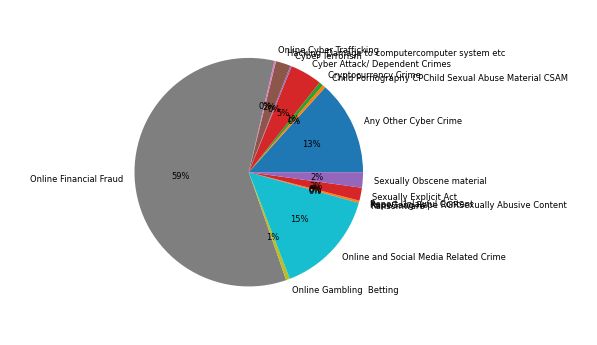

In [46]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, tight_layout=True, dpi = 300)

df_explore.groupby(['category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))

plt.show()

##### Distribution of reports by sub-categories

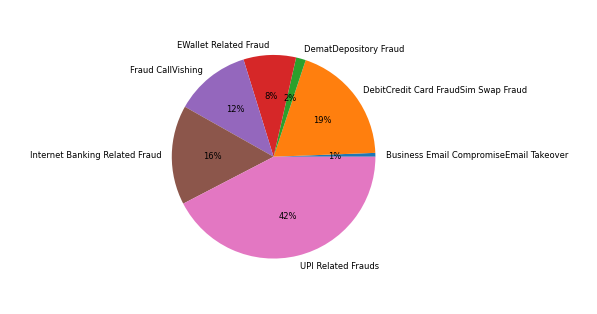

In [47]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, tight_layout=True, dpi = 300)

df_explore.query('category=="Online Financial Fraud"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))
#df_explore.query('category=="Online and Social Media Related Crime"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))
#df_explore.query('category=="Cyber Attack/ Dependent Crimes"').groupby(['sub_category']).size().plot(ax = axs, kind='pie', y='reports', autopct='%1.0f%%', fontsize=2, figsize = (2,2))

plt.show()

##### Let's look at distribution of report lengths (after removing redundant spaces)

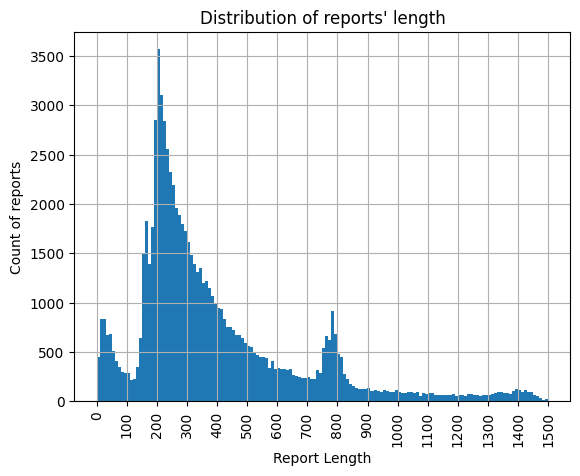

In [48]:
from matplotlib import ticker

fig, ax = plt.subplots()
ax.hist(df_explore['report_length'], bins = 150)

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xticks(fontsize=10, rotation=90)

ax.grid(True)
#ax.legend(loc='right')
ax.set_title("Distribution of reports' length")
ax.set_xlabel('Report Length')
ax.set_ylabel('Count of reports')

plt.show()

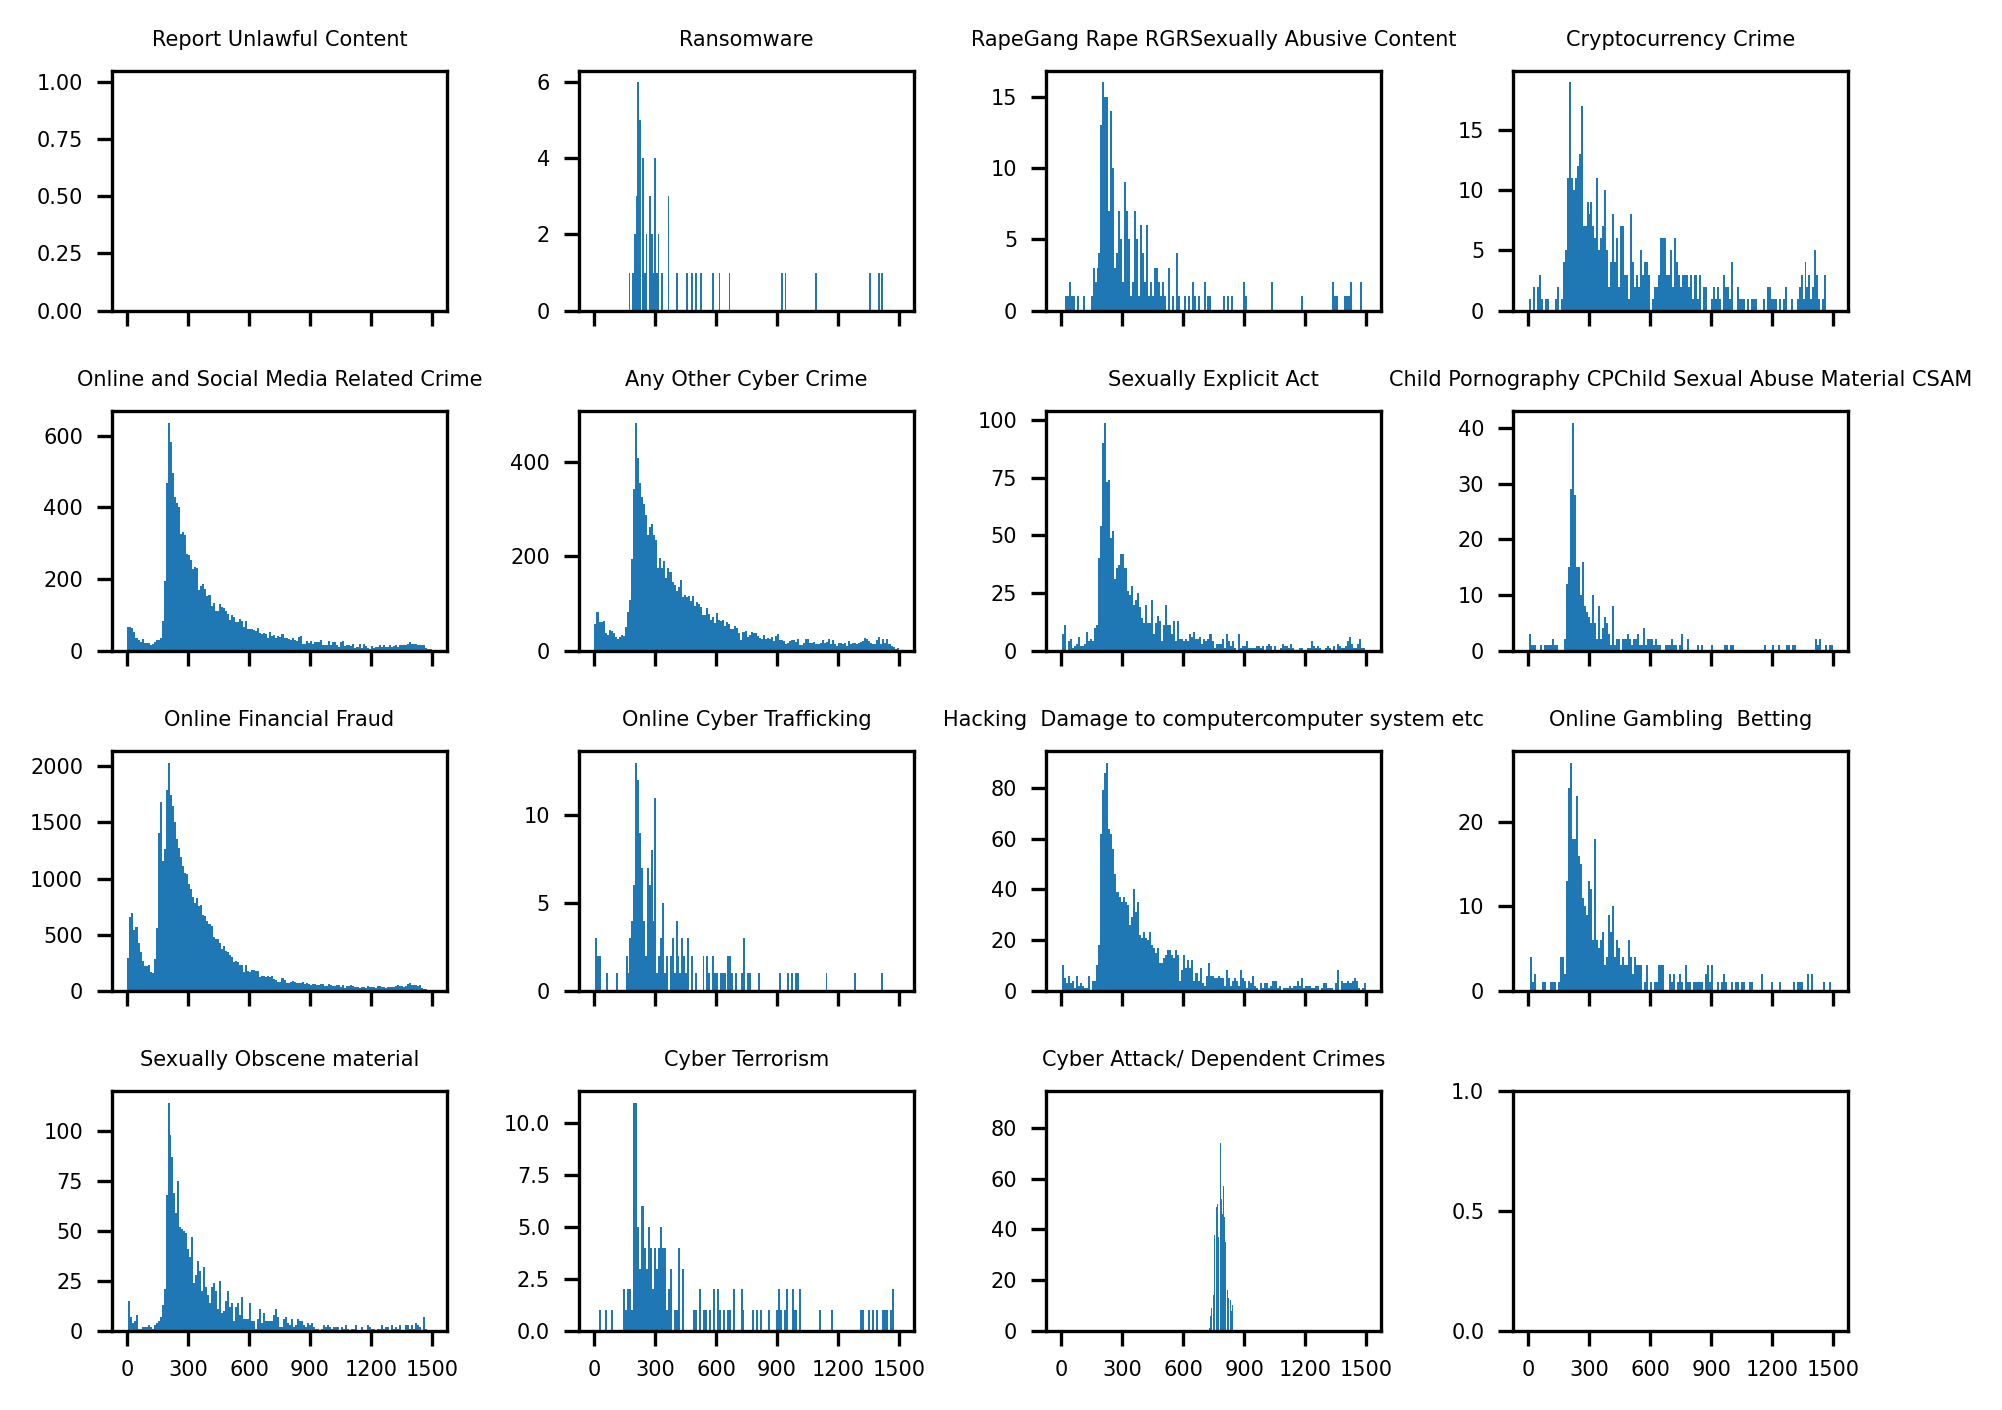

In [49]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, sharex = True, sharey = False, tight_layout = True, dpi = 300)

categories = list(set(df_explore['category']))

for pos, val in enumerate(categories):
    axs[pos // 4][pos % 4].hist(df_explore[df_explore['category'] == val]['report_length'], bins = 150)
    axs[pos // 4][pos % 4].set_title(val, fontdict = {'fontsize': 5})
    axs[pos // 4][pos % 4].xaxis.set_major_locator(ticker.MultipleLocator(300))
    axs[pos // 4][pos % 4].tick_params(axis='both', labelsize=5)


plt.xticks(fontsize=5) # For last empty box
plt.yticks(fontsize=5) # For last empty box

plt.show()

##### Export Data for Exploration

In [50]:
df_explore.to_csv(os.path.join("Output Data","99_explore_train_data.csv"), index=False)

# Explore & Get Top N on key-words for each category & sub-category

In [51]:

#df_explore = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","99_explore_train_data.csv"), sep = ",", header = 0)
#df_preprocessed_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_train_data_final.csv"), sep = ",", header = 0)

##### Let's look at commonly occuring words

In [52]:
temp = df_explore['report_aft_swr_lem']

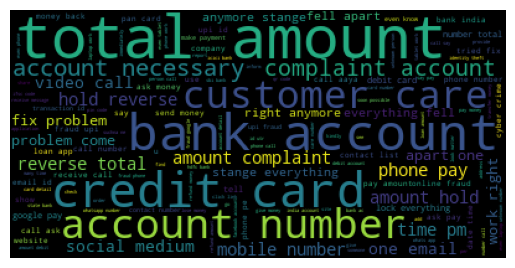

In [53]:
temp_text = ' '.join(map(str,temp))
wordcloud = WordCloud().generate(temp_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [54]:
# Get top n words (overall)

#n_top_key_words = 75

#temp_text_vec = temp_text.split(' ')
#temp_text_vec = [x for (x,y) in pos_tag(temp_text_vec) if y[0].lower() in ['a', 'n', 'v']]
#nltk.FreqDist(temp_text_vec).most_common(n_top_key_words)

##### Create list of most common words for each category
##### (report length>=150 and major_language==en & category != Report Unlawful Content)

In [55]:

def get_key_words_by_category(df_input, n_top_key_words = 75, report_length_thresh = 150):

    '''
    Returns a dataframe with top n words for each category.

            Parameters:
                    df_input: dataframe 
                        Clean & pre-processed dataframe
                    n_top_key_words: int, default=75
                        Count of most frequent words to be taken from each category
                    report_length_thresh: int, default=150
                        Threshold on length of reports to be considered to get frequent words from.
                        PLEASE NOTE to not keep it too low because reports with low length might not have enough context

            Returns:
                    key_words_cat: dataframe
                        Dataframe with top n words for each category
    '''
    
    start = time.time()

    categories = df_input['category'].sort_values().unique()
    categories = list(categories)
    key_words_cat = pd.DataFrame()
    
    for val in categories:
        temp = df_input.query('category == @val & report_length >= @report_length_thresh & major_language == "en" & category != "Report Unlawful Content"')['report_aft_swr_lem']
        temp_text = ' '.join(map(str,temp))
        temp_text_vec = temp_text.split(' ')
        temp_text_vec = [x for (x,y) in pos_tag(temp_text_vec) if y[0].lower() in ['a', 'n', 'v']]
        temp_text_vec = nltk.FreqDist(temp_text_vec).most_common(n_top_key_words)
        key_words_cat[val] = temp_text_vec + ([('x',0)]*(n_top_key_words - len(temp_text_vec) ))

    end = time.time()
    print("Execution time of getting top ",n_top_key_words, " key words for each category is :",(end-start)/60, "minutes")
    
    return key_words_cat

In [56]:
key_words_cat = get_key_words_by_category(df_preprocessed_final, n_top_key_words = 75)

Execution time of getting top  75  key words for each category is : 2.4785170356432595 minutes


In [57]:
key_words_cat.head(1)

,Any Other Cyber Crime,Child Pornography CPChild Sexual Abuse Material CSAM,Cryptocurrency Crime,Cyber Attack/ Dependent Crimes,Cyber Terrorism,Hacking Damage to computercomputer system etc,Online Cyber Trafficking,Online Financial Fraud,Online Gambling Betting,Online and Social Media Related Crime,Ransomware,RapeGang Rape RGRSexually Abusive Content,Sexually Explicit Act,Sexually Obscene material
0,"(number, 6565)","(call, 143)","(money, 432)","(everything, 9024)","(call, 110)","(loan, 1328)","(number, 101)","(amount, 34718)","(money, 460)","(call, 7163)","(file, 57)","(call, 136)","(call, 1101)","(call, 1252)"


##### Export key words list - All categories

In [58]:
key_words_cat.to_csv(os.path.join("Output Data","04_key_words_train_data_by_category.csv"), index=False)

##### Create list of most common words for each sub category
##### (report length>=150 and major_language==en & category != Report Unlawful Content)

In [59]:

def get_key_words_by_sub_category(df_input, n_top_key_words = 75, report_length_thresh = 150):

    '''
    Returns a dataframe with top n words for each sub-category.

            Parameters:
                    df_input: dataframe 
                        Clean & pre-processed dataframe
                    n_top_key_words: int, default=75
                        Count of most frequent words to be taken from each sub-category
                    report_length_thresh: int, default=150
                        Threshold on length of reports to be considered to get frequent words from.
                        PLEASE NOTE to not keep it too low because reports with low length might not have enough context

            Returns:
                    key_words_sub_cat: dataframe
                        Dataframe with top n words for each sub-category
    '''

    
    start = time.time()

    sub_categories = df_input[['category', 'sub_category']].sort_values(by = ['category','sub_category'])
    sub_categories = list(sub_categories['sub_category'].unique())
    key_words_sub_cat = pd.DataFrame()
    
    for val in sub_categories:
        temp = df_input.query('sub_category == @val & report_length >= @report_length_thresh & major_language == "en" & category != "Report Unlawful Content"')['report_aft_swr_lem']
        temp_text = ' '.join(map(str,temp))
        temp_text_vec = temp_text.split(' ')
        temp_text_vec = [x for (x,y) in pos_tag(temp_text_vec) if y[0].lower() in ['a', 'n', 'v']]
        temp_text_vec = nltk.FreqDist(temp_text_vec).most_common(n_top_key_words)
        key_words_sub_cat[val] = temp_text_vec + ([('x',0)]*(n_top_key_words - len(temp_text_vec) ))
    
    end = time.time()
    print("Execution time of getting top ",n_top_key_words, " key words for each sub-category is :",(end-start)/60, "minutes")

    return key_words_sub_cat

In [60]:
key_words_sub_cat = get_key_words_by_sub_category(df_preprocessed_final, n_top_key_words = 75, report_length_thresh = 150)

Execution time of getting top  75  key words for each sub-category is : 2.3882280429204306 minutes


In [61]:
key_words_sub_cat.head(1)

,Other,Child Pornography CPChild Sexual Abuse Material CSAM,Cryptocurrency Fraud,Data Breach/Theft,Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks,Hacking/Defacement,Malware Attack,Ransomware Attack,SQL Injection,Tampering with computer source documents,...,Impersonating Email,Intimidating Email,Online Job Fraud,Online Matrimonial Fraud,Profile Hacking Identity Theft,Provocative Speech for unlawful acts,Ransomware,RapeGang Rape RGRSexually Abusive Content,Sexually Explicit Act,Sexually Obscene material
0,"(number, 6565)","(call, 143)","(money, 432)","(everything, 1227)","(everything, 1260)","(everything, 1355)","(everything, 1293)","(everything, 1339)","(everything, 1255)","(everything, 1295)",...,"(email, 51)","(email, 34)","(pay, 809)","(call, 86)","(account, 2539)","(call, 156)","(file, 57)","(call, 136)","(call, 1101)","(call, 1252)"


##### Export key words list - All sub categories

In [62]:
key_words_sub_cat.to_csv(os.path.join("Output Data","04_key_words_train_data_by_sub_category.csv"), index=False)

# Prepare final list of key words (features)

In [63]:

#key_words = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","04_key_words_train_data_by_sub_category.csv"), sep = ",", header = 0)

In [64]:
key_words = copy.deepcopy(key_words_sub_cat)

##### Create short master list of key words
##### (using top n words from each sub-category to give equal weightage to each sub-cat)

In [65]:
# Get words (removing frequency) for each sub-category
sub_categories = list(key_words.columns)
n_top_key_words = 75
for r in range(0,n_top_key_words):
    for c in sub_categories:
        key_words.loc[:,c] = key_words.loc[:,c].astype(str)
        key_words.loc[r,c] = key_words[c][r].split("'")[1].split("'")[0]

key_words.head(1)

,Other,Child Pornography CPChild Sexual Abuse Material CSAM,Cryptocurrency Fraud,Data Breach/Theft,Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks,Hacking/Defacement,Malware Attack,Ransomware Attack,SQL Injection,Tampering with computer source documents,...,Impersonating Email,Intimidating Email,Online Job Fraud,Online Matrimonial Fraud,Profile Hacking Identity Theft,Provocative Speech for unlawful acts,Ransomware,RapeGang Rape RGRSexually Abusive Content,Sexually Explicit Act,Sexually Obscene material
0,number,call,money,everything,everything,everything,everything,everything,everything,everything,...,email,email,pay,call,account,call,file,call,call,call


In [66]:
key_words.to_csv(os.path.join("Output Data","05_only_key_words_train_data_by_sub_category.csv"), index=False)

In [67]:
key_word_list = []
for r in range(0,n_top_key_words):
    for c in sub_categories:
        key_word_list.append(key_words.loc[r,c])

key_word_list = list(set(key_word_list))


In [68]:
len(key_word_list)

414

In [69]:
to_remove = ['x','']

# Removing elements
for item in to_remove:
    if item in key_word_list:
        key_word_list.remove(item)

len(key_word_list)

414

In [70]:
#key_word_list

##### Save key-words list

In [71]:
# store list in binary file so 'wb' mode

with open(os.path.join('Output Data', 'key_word_list_top_75_sub_cat'), 'wb') as file:
    pickle.dump(key_word_list, file)
    file.close()

print('Done writing key word list into a binary file')

Done writing key word list into a binary file


# Vectorization of reports

In [184]:

#df_preprocessed_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_train_data_final.csv"), sep = ",", header = 0)
#df_preprocessed_test_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_test_data_final.csv"), sep = ",", header = 0)

##### Load list of manually identified key-words

In [73]:
## Read binary file to memory. So, 'rb' mode

#with open(os.path.join('Output Data', 'key_word_list_top_75_sub_cat'), 'rb') as file:
#    kw_list = pickle.load(file)
#    file.close()

#print('Done reading key word list into a list variable (kw_list)')

##### Vectorize using TF-IDF with manually identified key-words

In [185]:
# Define function to vectorize reports

def vectorize_reports_tf_idf(df_input, use_trained_idf = 'yes', vectorizer_file_name = "1_tf_idf_transformer.pkl"):

    '''
    Returns a dataframe with vectorized dependent (X) variables.

            Parameters:
                    df_input: dataframe 
                        Clean & pre-processed dataframe to be vectorized
                    use_trained_idf: {'yes', 'no'}, default = 'yes'
                        Flag to decide if already trained IDF transformer should be used (yes) or should it train a new one (no) 
                    vectorizer_file_name: string, default = "1_tf_idf_transformer.pkl" 
                        File name of IDF transformer to be loaded if using trained/saved version. If not already available, train a new one & save
                        it with this name

            Returns:
                    df_output: dataframe
                        Dataframe with vectorized dependent (X) variables
    '''
    
    start = time.time()

    with open(os.path.join('Output Data', 'key_word_list_top_75_sub_cat'), 'rb') as file:
        kw_list = pickle.load(file)
        file.close()
    
    print('Done reading key word list into a list variable (kw_list)')

    # Initialize count vectorizer to count term frequency (count) restricting vocabulary to only kw_list
    count_vectorizer = CountVectorizer(vocabulary = kw_list)

    # Get term frequency / word count of keywords in reports
    word_count_vector = count_vectorizer.fit_transform(df_input['report_aft_swr_lem'])

    # Get idf of keywords
    if use_trained_idf == 'yes':
        # Load already trained idf values
        with open(os.path.join("Vectorizers",vectorizer_file_name), 'rb') as file:
            tfidf_transformer = pickle.load(file)
            file.close()
        print(vectorizer_file_name, ": TF-IDF transformer loaded!")
    else:
        # Train idf of keywords
        tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        # Save trained idf transformer to preserve learnt idf values
        with open(os.path.join("Vectorizers",vectorizer_file_name), 'wb') as file:
            pickle.dump(tfidf_transformer, file)
            file.close()
        print(vectorizer_file_name, ": TF-IDF transformer saved!")

    # Get tf-idf values for each word in reports 
    X_tf_idf = tfidf_transformer.transform(word_count_vector)

    X_tf_idf = pd.DataFrame(X_tf_idf.toarray(), columns=count_vectorizer.get_feature_names_out())
    X_tf_idf.sort_index(axis=1, inplace=True) # Sorting columns in ascending order of names (key words)

    print("Shape of input dataframe: ", df_input.shape, "Shape of vectorized dataframe (before concat with input): ", X_tf_idf.shape)
    # Add back reports to vectorized data
    if df_input.shape[0] == X_tf_idf.shape[0]:
        df_output = pd.concat([df_input, X_tf_idf], axis=1)
    else:
        print("ERROR!: Please make sure that # Rows are same in input dataframe and vectorized dataframe")

    end = time.time()
    print("Execution time of TF-IDF based report vectorization is :",(end-start)/60, "minutes")

    return df_output

#### Prepare final training dataset (list of clean reports after cleaning, preprocessing, vectorization)

##### Vectorize training data

In [186]:
df_vectorized_train = vectorize_reports_tf_idf(df_preprocessed_final, use_trained_idf = 'no', vectorizer_file_name = "1_tf_idf_transformer.pkl")

Done reading key word list into a list variable (kw_list)
1_tf_idf_transformer.pkl : TF-IDF transformer saved!
Shape of input dataframe:  (67174, 9) Shape of vectorized dataframe (before concat with input):  (67174, 414)
Execution time of TF-IDF based report vectorization is : 0.05513914028803508 minutes


In [187]:
df_vectorized_train.head(1)

,category,sub_category,reports,report_length,report_aft_swr,report_aft_swr_lem,language_probability,major_language,major_probability,aaya,...,whatsapp,wife,withdrawal,woman,word,work,year,yesterday,yono,youtube
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,i had continue received random calls and abusi...,255,continue received random calls abusive message...,continue receive random call abusive message w...,[en:0.9999953231921757],en,0.9999,0.0,...,0.243693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Export vectorized training data

In [188]:
df_vectorized_train.to_csv(os.path.join("Output Data","06_vectorized_train_data.csv"), index=False)

##### Vectorize test data (NOTE: Use trained IDFs)

In [189]:
df_vectorized_test = vectorize_reports_tf_idf(df_preprocessed_test_final, use_trained_idf = 'yes', vectorizer_file_name = "1_tf_idf_transformer.pkl")

Done reading key word list into a list variable (kw_list)
1_tf_idf_transformer.pkl : TF-IDF transformer loaded!
Shape of input dataframe:  (27334, 9) Shape of vectorized dataframe (before concat with input):  (27334, 414)
Execution time of TF-IDF based report vectorization is : 0.01948008139928182 minutes


In [190]:
df_vectorized_test.head(1)

,category,sub_category,reports,report_length,report_aft_swr,report_aft_swr_lem,language_probability,major_language,major_probability,aaya,...,whatsapp,wife,withdrawal,woman,word,work,year,yesterday,yono,youtube
0,RapeGang Rape RGRSexually Abusive Content,RapeGang Rape RGRSexually Abusive Content,sir namaskar mein ranjit kumar patrapaise nehi...,730,namaskar mein ranjit kumar patrapaise nehi tho...,namaskar mein ranjit kumar patrapaise nehi tho...,"[en:0.8571401891708754, so:0.14285615375411745]",en,0.8571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Export vectorized test data

In [191]:
df_vectorized_test.to_csv(os.path.join("Output Data","06_vectorized_test_data.csv"), index=False)

# Model Selection

In [2]:
#df_vectorized_train = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","06_vectorized_train_data.csv"), sep = ",", header = 0)
#df_vectorized_test = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","06_vectorized_test_data.csv"), sep = ",", header = 0)

##### Removing 'Crime Against Women & Children' category from test data because this is not present in training data 

In [3]:
df_train = copy.deepcopy(df_vectorized_train)
df_test = copy.deepcopy(df_vectorized_test)

df_test = df_test.query('category != "Crime Against Women & Children"').reset_index(drop=True)

##### Function to train models & test their performance

In [4]:
# Define function for training model and testing performance

def run_model(training_data, testing_data, ml_model, ml_model_name, label='category', sampling_model = None, one_hot_label = 'no', save_ml_model = 'yes'):
    
    '''
    Returns a dictionary with performance metrics (accuracy, f1-score, precision and recall) of model on training, validation and testing data.

            Parameters:
                    training_data: dataframe 
                        Vectorized training data
                    testing_data: dataframe
                        Vectorized test data
                    ml_model: model
                        Selected machine learning model
                    ml_model_name: string
                        Name with which the machine learning model should be addressed / saved
                    label: {'category', 'sub_category'}, default='category'
                        Dependent variable (y) name in training & testing data
                    sampling_model: model, default=None
                        Selected sampling model meant for balancing training dataset
                    one_hot_label: {'no', 'yes'}, default='no'
                        It determines whether dependent variable (y) should be one-hot encoded or not
                    save_ml_model: {'no', 'yes'}, default='yes'
                        It determines whether trained ml_model should be saved or not

            Returns:
                    performance_dict: dictionary
                        Dictionary containing performance metrics of model
    '''
    
    # Split total training data into training & validation sets 
    X = training_data.iloc[:,9:]
    y = training_data.loc[:,[label]] # To train on category / sub_category change the column to category / sub_category

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y_encoded= label_encoder.transform(y)

    # DON'T change stratify to category even if you train model at category level (stratification at sub_category level is better to cover all type of reports)
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=1, stratify=training_data.loc[:,['sub_category']])

    # Create X, y variables for testing data
    #testing_data = testing_data.query('category != "Crime Against Women & Children"').reset_index(drop=True)
    X_test = testing_data.iloc[:,9:]
    y_test = testing_data.loc[:,[label]] # To train on category / sub_category change the column to category / sub_category
    #y_test_encoded= label_encoder.transform(y_test) # No need to label encode y_test

    print('Data splitting & label encoding done')
    
    # Balancing training data
    if sampling_model is None:
        print('Sampling model not selected for data balancing')
    else:
        X_train, y_train = sampling_model.fit_resample(X_train, y_train)
        print('Training data balancing done using selected sampling model')

    # Convert labels (y) to one hot encoding if requested
    if one_hot_label == 'no':
        print('One hot encoding is not selected')
    else:
        n_classes = max(y_encoded)+1
        y_train = to_categorical(y_train, n_classes)
        # One hot encoding not needed for y_val & y_test_encoded because model fitting takes only training data which should be OH encoded

    # Fit model
    ml_model.fit(X_train, y_train)
    print(ml_model_name,' model is now trained')

    # Generate predictions
    y_pred_train = ml_model.predict(X_train)
    print('Prediction for training data is done')
    
    y_pred_val = ml_model.predict(X_val)
    print('Prediction for validation data is done')
    
    y_pred_test = ml_model.predict(X_test)
    print('Prediction for test data is done')

    # Invert encoding transformations
    
    ## Inverting one hot encoding
    if one_hot_label == 'no':
        print('.')
    else:
        y_pred_train = np.argmax(y_pred_train, axis=1)
        y_pred_val = np.argmax(y_pred_val, axis=1)
        y_pred_test = np.argmax(y_pred_test, axis=1)

    ## Inverting label encoding
    y_pred_train = label_encoder.inverse_transform(y_pred_train)
    y_pred_val = label_encoder.inverse_transform(y_pred_val)
    y_pred_test = label_encoder.inverse_transform(y_pred_test)
    y_train = label_encoder.inverse_transform(y_train)
    y_val = label_encoder.inverse_transform(y_val)
    #'y_test' is already available with label names. So, no need to inverse transform 'y_test_encoded'

    print('Inverse encoding of labels is done')
    
    performance_dict = dict()

    # Performance on training data
    performance_dict['accuracy_train'] = accuracy_score(y_train, y_pred_train)
    performance_dict['f1_train'] = f1_score(y_train, y_pred_train, average='weighted')
    performance_dict['precision_train'] = precision_score(y_train, y_pred_train, average='weighted')
    performance_dict['recall_train'] = recall_score(y_train, y_pred_train, average='weighted')

    print("Accuracy (Training data): ", accuracy_score(y_train, y_pred_train)) 
    print("F1-score (Training data): ", f1_score(y_train, y_pred_train, average='weighted')) 
    print("Precision (Training data): ", precision_score(y_train, y_pred_train, average='weighted')) 
    print("Recall (Training data): ", recall_score(y_train, y_pred_train, average='weighted'))
    
    # Performance on validation data
    performance_dict['accuracy_val'] = accuracy_score(y_val, y_pred_val)
    performance_dict['f1_val'] = f1_score(y_val, y_pred_val, average='weighted')
    performance_dict['precision_val'] = precision_score(y_val, y_pred_val, average='weighted')
    performance_dict['recall_val'] = recall_score(y_val, y_pred_val, average='weighted')

    print("Accuracy (Validation data): ", accuracy_score(y_val, y_pred_val)) 
    print("F1-score (Validation data): ", f1_score(y_val, y_pred_val, average='weighted')) 
    print("Precision (Validation data): ", precision_score(y_val, y_pred_val, average='weighted')) 
    print("Recall (Validation data): ", recall_score(y_val, y_pred_val, average='weighted')) 
    
    # Performance on test data
    performance_dict['accuracy_test'] = accuracy_score(y_test, y_pred_test)
    performance_dict['f1_test'] = f1_score(y_test, y_pred_test, average='weighted')
    performance_dict['precision_test'] = precision_score(y_test, y_pred_test, average='weighted')
    performance_dict['recall_test'] = recall_score(y_test, y_pred_test, average='weighted')

    print("Accuracy (Testing data): ", accuracy_score(y_test, y_pred_test)) 
    print("F1-score (Testing data): ", f1_score(y_test, y_pred_test, average='weighted')) 
    print("Precision (Testing data): ", precision_score(y_test, y_pred_test, average='weighted')) 
    print("Recall (Testing data): ", recall_score(y_test, y_pred_test, average='weighted')) 

    
    # Printing classification report
    print("Classification Report based on training data:\n", classification_report(y_train,y_pred_train))
    print("Classification Report based on validation data:\n", classification_report(y_val,y_pred_val))
    print("Classification Report based on testing data:\n ", classification_report(y_test,y_pred_test))

    # Save model
    if save_ml_model == 'yes':
        model_pkl_file = ml_model_name + '.pkl'
        
        if sampling_model is None:
            with open(os.path.join("Models", label, model_pkl_file), 'wb') as file:
                pickle.dump(ml_model, file)
                file.close()
                print("Model saved!")
        else:
            with open(os.path.join("Models", label, "with_balanced_data", model_pkl_file), 'wb') as file:
                pickle.dump(ml_model, file)
                file.close()
                print("Model saved!")
    else:
        print("Model not saved")
    
    return performance_dict

##### Create list of ML Models to test

In [5]:
# Create dictionary of ML models
def get_ml_models(for_balanced_data = 'no'):

    '''
    Returns a dictionary with machine learning models.

            Parameters:
                    for_balanced_data: {'no', 'yes'}, default='no'
                        It determines whether ml models should be chosen from set of models meant for imbalanced data (no) or balanced data (yes).
                        PLEASE NOTE to Mark it as 'yes' if sampling model is being used to balance imbalanced data before it enters ml model

            Returns:
                    models: dictionary
                        Dictionary with machine learning models
    '''
    
    models = dict()
    
    if for_balanced_data == 'no':
        # Use below models if data is imbalanced
        models['1_svm_balanced_weights'] = LinearSVC(class_weight='balanced', random_state=1)
        models['2_xgb_no_weight_change'] = XGBClassifier(random_state=1)
        models['3_rf_balanced_weights'] = RandomForestClassifier(class_weight='balanced', random_state=1)
    else:
        # Use below models if data is balanced
        models['4_svm_wo_balanced_weights_bal_data'] = LinearSVC(random_state=1)
        models['5_xgb_no_weight_change_bal_data'] = XGBClassifier(random_state=1)
        models['6_rf_wo_balanced_weights_bal_data'] = RandomForestClassifier(random_state=1)
        
    return models

##### Select sampling model for balancing dataset

In [6]:
selected_sampling_model = RandomOverSampler()

##### Select ml models

In [7]:
# Select for_balanced_data = 'yes' IF sampling model is being used to balance the training dataset
ml_models = get_ml_models(for_balanced_data = 'no')

##### Run Models

In [8]:
# AT CATEGORY LEVEL

performance_summary_dict = dict()

for selected_ml_model_name, selected_ml_model in ml_models.items():
    print("Running ", selected_ml_model_name, " model.")
    start = time.time()
    
    # Set sampling_model = selected_sampling_model if sampling model is being used
    # Set sampling_model = None if sampling model not being used
    performance_summary_dict[selected_ml_model_name] = run_model(training_data = df_train, testing_data = df_test,
                                                        ml_model = selected_ml_model, ml_model_name = selected_ml_model_name,
                                                        label='category', sampling_model = None, one_hot_label = 'no', save_ml_model = 'yes')
    
    end = time.time()
    print(selected_ml_model_name," : Training & testing completed in : ", (end-start)/60, " minutes.\n")


Running  1_svm_balanced_weights  model.
Data splitting & label encoding done
Sampling model not selected for data balancing
One hot encoding is not selected
1_svm_balanced_weights  model is now trained
Prediction for training data is done
Prediction for validation data is done
Prediction for test data is done
.
Inverse encoding of labels is done
Accuracy (Training data):  0.6072605856957529
F1-score (Training data):  0.6476235737645155
Precision (Training data):  0.7267928380635685
Recall (Training data):  0.6072605856957529
Accuracy (Validation data):  0.5851734233116658
F1-score (Validation data):  0.6300457028354812
Precision (Validation data):  0.7070150983293687
Recall (Validation data):  0.5851734233116658
Accuracy (Testing data):  0.5834979875594585
F1-score (Testing data):  0.6310181688710259
Precision (Testing data):  0.7124886334683442
Recall (Testing data):  0.5834979875594585
Classification Report based on training data:
                                                     

In [9]:
# AT SUB-CATEGORY LEVEL

performance_summary_dict_sub = dict()

for selected_ml_model_name, selected_ml_model in ml_models.items():
    print("Running ", selected_ml_model_name, " model.")
    start = time.time()
    
    # Set sampling_model = selected_sampling_model if sampling model is being used
    # Set sampling_model = None if sampling model not being used
    performance_summary_dict_sub[selected_ml_model_name] = run_model(training_data = df_train, testing_data = df_test,
                                                        ml_model = selected_ml_model, ml_model_name = selected_ml_model_name,
                                                        label='sub_category', sampling_model = None, one_hot_label = 'no', save_ml_model = 'yes')
    
    end = time.time()
    print(selected_ml_model_name," : Training & testing completed in : ", (end-start)/60, " minutes.\n")


Running  1_svm_balanced_weights  model.
Data splitting & label encoding done
Sampling model not selected for data balancing
One hot encoding is not selected
1_svm_balanced_weights  model is now trained
Prediction for training data is done
Prediction for validation data is done
Prediction for test data is done
.
Inverse encoding of labels is done
Accuracy (Training data):  0.40086344399310947
F1-score (Training data):  0.4091345095328783
Precision (Training data):  0.5046212125248953
Recall (Training data):  0.40086344399310947
Accuracy (Validation data):  0.3646107279313254
F1-score (Validation data):  0.38384215195134
Precision (Validation data):  0.4784909949359952
Recall (Validation data):  0.3646107279313254
Accuracy (Testing data):  0.3660446395901939
F1-score (Testing data):  0.38777194392809555
Precision (Testing data):  0.4799027033574554
Recall (Testing data):  0.3660446395901939
Classification Report based on training data:
                                                    

# Explore Models

In [10]:

#df_vectorized_train = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","06_vectorized_train_data.csv"), sep = ",", header = 0)
#df_vectorized_test = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","06_vectorized_test_data.csv"), sep = ",", header = 0)

##### Select y_label (category vs sub_category)

In [63]:
# Select model level (label = category OR sub_category)
label = 'category'

##### Split full training dataset into 2 parts: Training set and Validation set

In [64]:
# Training model to classify on CATEGORIES (not SUB_CATEGORIES)

X = df_vectorized_train.iloc[:,9:]
y = df_vectorized_train.loc[:,[label]]

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)

y_encoded= label_encoder.transform(y)

# DON'T change stratify to category even if you train model at category level (stratification at sub_category level is better to cover all type of reports)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=1, stratify=df_vectorized_train.loc[:,['sub_category']])

##### Save label encoder

In [65]:
label_encoder_pkl_file = label+"_encoder.pkl"  

with open(os.path.join("Vectorizers",label_encoder_pkl_file), 'wb') as file:
    pickle.dump(label_encoder, file)
    file.close()

print(label, ": Label encoder saved!")

category : Label encoder saved!


##### Select sampling model to balance the training data

In [13]:
## Balancing training data

#sampling_model = RandomOverSampler()
#X_train, y_train = sampling_model.fit_resample(X_train, y_train)

In [14]:
# Record count for each label (category or sub-category)
Counter(y_train)

Counter({7: 26754,
         9: 7149,
         0: 6455,
         3: 2525,
         13: 1072,
         5: 970,
         12: 911,
         2: 306,
         8: 270,
         1: 210,
         11: 147,
         6: 111,
         4: 103,
         10: 38})

##### Encode target variable in test dataset

In [15]:
## Preparing test data to check model performance

df_vectorized_test_final = df_vectorized_test.query('category != "Crime Against Women & Children" & category != "Report Unlawful Content"').reset_index(drop=True)
X_test = df_vectorized_test_final.iloc[:,9:]
y_test = df_vectorized_test_final.loc[:,[label]] # To train on category / sub_category change the column to category / sub_category

y_test_encoded= label_encoder.transform(y_test)

##### One hot encoding of target variable

In [16]:
n_classes = max(y_encoded)+1

Y_train_one_hot = to_categorical(y_train, n_classes)
Y_val_one_hot = to_categorical(y_val, n_classes)

Y_test_one_hot = to_categorical(y_test_encoded, n_classes)

In [17]:
print("Number of independent variables (X): ", X.shape[1])
print("Number of labels in dependent variable (Y): ", Y_train_one_hot.shape[1])

Number of independent variables (X):  414
Number of labels in dependent variable (Y):  14


##### Train model

In [18]:
# Try multiple models

# (1) Linear Support Vector Machine (with balancing of weights)
#model = LinearSVC(class_weight='balanced', random_state=1) #notice the “balanced” option to handle imbalanced dataset
#model.fit(X_train, y_train) #fit the model with training data

# (2) XG Boost
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train) #fit the model with training data

# (3) Random Forest (with balancing of weights)
#model = RandomForestClassifier(class_weight='balanced', random_state=1)
#model.fit(X_train, y_train) #fit the model with training data

# (4) Linear Support Vector Machine (with no balancing of weights)
#model = LinearSVC(random_state=1)
#model.fit(X_train, y_train) #fit the model with training data

# (5) Random Forest (with no balancing of weights)
#model = RandomForestClassifier(random_state=1) # Same weightage to each category
#model.fit(X_train, y_train) #fit the model with training data

# (6) Neural network
#layer_input = Input(shape = (X.shape[1],))
#layer_1 = Dense(100, activation="relu")(layer_input)
#layer_output= Dense(Y_train_one_hot.shape[1], activation="softmax")(layer_1)
#model = Model(inputs=layer_input, outputs=layer_output)

#model.summary()
#model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam') # categorical_accuracy is used for multi-class classification
#model.fit(X_train, Y_train_one_hot, batch_size=100, epochs=10, validation_data=(X_val, Y_val_one_hot))

# (7) Try using BERT
# Code for BERT is at the end
# Couldn't try BERT as laptop it requires more computation power than my laptop's (got Out of Memory error)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

##### Load saved model (in case already saved)

In [19]:
## Read binary file to memory. So, 'rb' mode

#model_file_name = "2_xgb_no_weight_change.pkl"

#with open(os.path.join("Models",label, model_file_name), 'rb') as file:
#    model = pickle.load(file)
#    file.close()

#print('Saved model loaded in memory')

#### Performance on Training Set

##### Generate predictions for training dataset

In [20]:
y_pred_train = model.predict(X_train)

## For neural network prediction
#y_pred_train = np.argmax(y_pred_train, axis=1)

In [21]:
print("Accuracy (training): ", accuracy_score(y_train, y_pred_train))
print("F1-score (training): ", f1_score(y_train, y_pred_train, average='weighted')) 
print("Precision (training): ", precision_score(y_train, y_pred_train, average='weighted')) 
print("Recall (training): ", recall_score(y_train, y_pred_train, average='weighted'))

Accuracy (training):  0.8223134344229174
F1-score (training):  0.8062682668067213
Precision (training):  0.8235199912492301
Recall (training):  0.8223134344229174


In [22]:
print("Classification Report based on training data:\n", classification_report(label_encoder.inverse_transform(y_train),label_encoder.inverse_transform(y_pred_train)))

Classification Report based on training data:
                                                       precision    recall  f1-score   support

                               Any Other Cyber Crime       0.77      0.42      0.54      6455
Child Pornography CPChild Sexual Abuse Material CSAM       0.95      0.75      0.84       210
                                Cryptocurrency Crime       0.98      0.87      0.92       306
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      2525
                                     Cyber Terrorism       1.00      0.60      0.75       103
      Hacking  Damage to computercomputer system etc       0.88      0.71      0.79       970
                            Online Cyber Trafficking       1.00      0.36      0.53       111
                              Online Financial Fraud       0.83      0.97      0.89     26754
                            Online Gambling  Betting       1.00      0.47      0.64       270
            

#### Performance on Validation Set

##### Generate predictions for validation dataset

In [23]:
y_pred = model.predict(X_val)

## For neural network prediction
#y_pred = np.argmax(y_pred, axis=1)

##### Cross Validation Score

In [24]:
#print(cross_val_score(model, X_train, y_train, cv=5))

##### Performance on validation dataset

In [25]:
print("Accuracy (validation): ", accuracy_score(y_val, y_pred))
print("F1-score (validation): ", f1_score(y_val, y_pred, average='weighted')) 
print("Precision (validation): ", precision_score(y_val, y_pred, average='weighted')) 
print("Recall (validation): ", recall_score(y_val, y_pred, average='weighted'))

Accuracy (validation):  0.7166674936733985
F1-score (validation):  0.6781563530770084
Precision (validation):  0.6686233626557739
Recall (validation):  0.7166674936733985


##### Classification Report on validation dataset

In [26]:
print("Classification Report based on validation data:\n", classification_report(label_encoder.inverse_transform(y_val),label_encoder.inverse_transform(y_pred)))

Classification Report based on validation data:
                                                       precision    recall  f1-score   support

                               Any Other Cyber Crime       0.46      0.23      0.31      2766
Child Pornography CPChild Sexual Abuse Material CSAM       0.52      0.26      0.34        90
                                Cryptocurrency Crime       0.65      0.42      0.51       131
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      1083
                                     Cyber Terrorism       0.00      0.00      0.00        44
      Hacking  Damage to computercomputer system etc       0.40      0.25      0.31       414
                            Online Cyber Trafficking       0.00      0.00      0.00        47
                              Online Financial Fraud       0.77      0.93      0.84     11468
                            Online Gambling  Betting       0.12      0.01      0.02       116
          

##### Save Model

In [27]:
model_pkl_file = "2_xgb_no_weight_change.pkl"  

with open(os.path.join("Models",label,model_pkl_file), 'wb') as file:
    pickle.dump(model, file)
    file.close()

print("Model saved!")

Model saved!


#### Performance on Testing set

##### Genrate predictions for test dataset

In [28]:
y_pred_test = model.predict(X_test)

## For neural network prediction
#y_pred_test = np.argmax(y_pred_test, axis=1)

##### Performance on test data

In [29]:
print("Accuracy (test): ", accuracy_score(y_test_encoded,y_pred_test))
print("F1-score (test): ", f1_score(y_test_encoded,y_pred_test, average='weighted')) 
print("Precision (test): ", precision_score(y_test_encoded,y_pred_test, average='weighted'))
print("Recall (test): ", recall_score(y_test_encoded,y_pred_test, average='weighted'))

Accuracy (test):  0.7216245883644347
F1-score (test):  0.6822372786078915
Precision (test):  0.6737282061031707
Recall (test):  0.7216245883644347


##### Classification Report on test dataset

In [30]:
print("Classification Report based on test data:\n", classification_report(y_test,label_encoder.inverse_transform(y_pred_test)))

Classification Report based on test data:
                                                       precision    recall  f1-score   support

                               Any Other Cyber Crime       0.43      0.20      0.28      3609
Child Pornography CPChild Sexual Abuse Material CSAM       0.59      0.24      0.34       114
                                Cryptocurrency Crime       0.55      0.38      0.45       162
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      1261
                                     Cyber Terrorism       0.00      0.00      0.00        51
      Hacking  Damage to computercomputer system etc       0.39      0.25      0.31       580
                            Online Cyber Trafficking       0.00      0.00      0.00        61
                              Online Financial Fraud       0.78      0.94      0.85     16051
                            Online Gambling  Betting       0.22      0.02      0.03       133
               O

In [31]:
test_predicted_labels = label_encoder.inverse_transform(y_pred_test)

In [32]:
test_predicted_labels = pd.DataFrame(test_predicted_labels, columns =['predicted_label'])

In [33]:
df_for_analysis = pd.concat([df_vectorized_test_final, test_predicted_labels], axis=1)

In [34]:
# For category level predictions
df_for_analysis.to_csv(os.path.join("Output Data","98_test_data_xgb_predicted_cat_labels.csv"), index=False)

## For sub_category level predictions
#df_for_analysis.to_csv(os.path.join("Output Data","98_test_data_xgb_predicted_subcat_labels.csv"), index=False)

#### Explore features (for XG Boost Model)

##### Saving Feature Importance (It will work for Random Forest & XGBoost)

In [35]:
feat_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feat_imp = feat_imp.sort_values('importance', ascending=False)

In [36]:
# For category
feat_imp.to_csv(os.path.join("Output Data","97_feature_importance_xgb_cat.csv"), index=False)

## For sub-category
#feat_imp.to_csv(os.path.join("Output Data","97_feature_importance_xgb_sub_cat.csv"), index=False)

##### Visualize feature importance (It will work for XGBoost only)

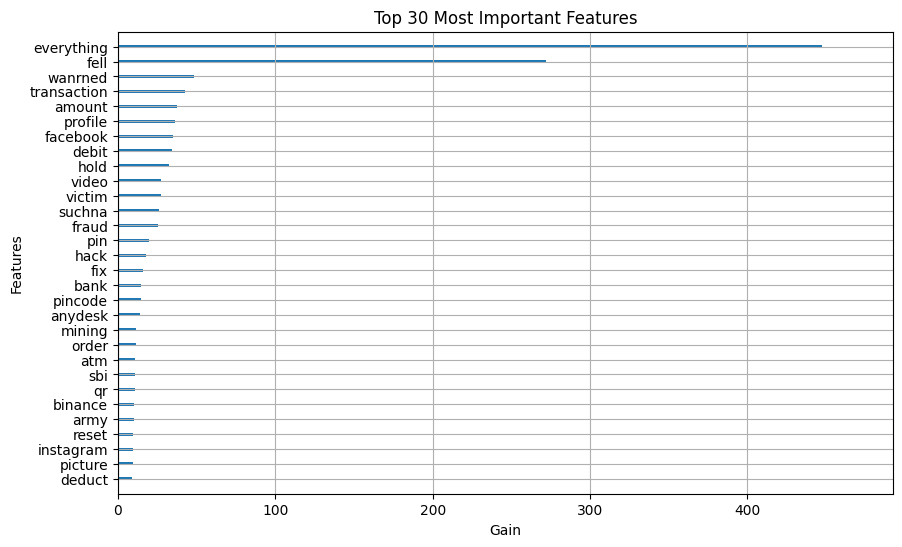

In [37]:
# Set the number of top features to plot

top_n = 30

# Plot feature importance with feature names

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=top_n, show_values=False)

plt.xlabel('Gain')
plt.title(f'Top {top_n} Most Important Features')
plt.show()

# Testing on real time report entry

In [38]:

# Create pipeline to pre-process and vectorize report
# Load Model
# Predict
# Load saved label encoder
# Invert label encoding to get category/sub-category name

In [5]:
def clean_text(text):

    '''
    Returns a clean string.
    Converts text to lower case, remove whitespaces, remove punctuations.

            Parameters:
                    text: string 
                        Raw input text

            Returns:
                    text: string
                        Clean output text
    '''
    
    text = text.lower() # Change text of reports to lowercase
    text = remove_punctuations(text) # Remove punctuations from report text

    # Replace redundant whitespaces from text
    text = ' '.join(text.split())
    
    return text

In [6]:
def pre_process_text(text):

    '''
    Returns pre-processed (stop word removal, lemmatization) string.

            Parameters:
                    text: string 
                        Clean text

            Returns:
                    text: string
                        Pre-processed text
    '''
    
    # Perform lemmatization & Remove stop-words
    text =  ' '.join(word for word in lemmatize_text(text))
    
    return text

In [13]:
def vectorize_text_tf_idf(text, vectorizer_file_name = "1_tf_idf_transformer.pkl"):

    '''
    Returns a dataframe with vectorized dependent (X) variables.

            Parameters:
                    text: string 
                        Pre-processed text
                    vectorizer_file_name: string
                        Name of trained idf transformer to be used for vectorization

            Returns:
                    X_tf_idf: dataframe
                        Dataframe with vectorized dependent (X) variables
    '''
    

    with open(os.path.join('Output Data', 'key_word_list_top_75_sub_cat'), 'rb') as file:
        kw_list = pickle.load(file)
        file.close()
    
    #print('Done reading key word list into a list variable (kw_list)')

    # Initialize count vectorizer to count term frequency (count) restricting vocabulary to only kw_list
    count_vectorizer = CountVectorizer(vocabulary = kw_list)

    # Convert input text to a list and then to dataframe (to make it iteratable and in same format as training data)
    df = pd.DataFrame([text], columns=['report_aft_swr_lem'])

    # Get term frequency / word count of keywords in reports
    word_count_vector = count_vectorizer.fit_transform(df['report_aft_swr_lem'])

    # Get idf of keywords
    # Load already trained idf values
    with open(os.path.join("Vectorizers",vectorizer_file_name), 'rb') as file:
        tfidf_transformer = pickle.load(file)
        file.close()
    
    #print(vectorizer_file_name, ": TF-IDF transformer loaded!")
    

    # Get tf-idf values for each word in reports 
    X_tf_idf = tfidf_transformer.transform(word_count_vector)

    X_tf_idf = pd.DataFrame(X_tf_idf.toarray(), columns=count_vectorizer.get_feature_names_out())
    X_tf_idf.sort_index(axis=1, inplace=True) # Sorting columns in ascending order of names (key words)


    return X_tf_idf

In [8]:
def load_classification_model(model_pkl_file = "2_xgb_no_weight_change.pkl", label = 'sub_category'):

    # Load model
    with open(os.path.join("Models", label, model_pkl_file), 'rb') as file:
        model = pickle.load(file)
        file.close()

    # Load label encoder
    with open(os.path.join("Vectorizers", label+"_encoder.pkl"), 'rb') as file:
        label_encoder = pickle.load(file)
        file.close()
    
    return model, label_encoder 

In [9]:
def predict_report_class(user_report_description, model, label_encoder):

    # Clean, process and vectorize user report description
    input = clean_text(user_report_description)
    input = pre_process_text(input)
    input = vectorize_text_tf_idf(input)
    
    # Load model & label encoder
    #model, label_encoder = load_classification_model(model_pkl_file = "2_xgb_no_weight_change.pkl", label = 'sub_category')

    # Predict report's class
    output = label_encoder.inverse_transform(model.predict(input))
    
    return output

In [10]:
model, label_encoder = load_classification_model(model_pkl_file = "2_xgb_no_weight_change.pkl", label = 'sub_category')

In [15]:
test_report = "paytm se paisa kaat k fraud kar diya"

In [16]:
predict_report_class(test_report, model, label_encoder)

array(['UPI Related Frauds'], dtype=object)

# Trying BERT (Ignore this: Went out of memory)

In [ ]:

#df_preprocessed_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_train_data_final.csv"), sep = ",", header = 0)
#df_preprocessed_test_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_test_data_final.csv"), sep = ",", header = 0)

In [ ]:

#df_preprocessed_bert = copy.deepcopy(df_preprocessed_final)
#df_preprocessed_bert = df_preprocessed_bert[['report_aft_swr_lem','category','sub_category']].drop_duplicates().reset_index(drop=True)

##### Select target label (category or sub_category)

In [ ]:
#label_col = 'category'

In [ ]:
#label_encoded_col = label+'_encoded'

##### Create training and validation set split

In [ ]:
#label_encoder_b = preprocessing.LabelEncoder()

#df_preprocessed_bert[label_encoded_col] = label_encoder_b.fit_transform(df_preprocessed_bert.loc[:,[label_col]]) 

## DON'T change stratify to category even if you train model at category level (stratification at sub_category level is better to cover all type of reports)
#train_b, val_b = train_test_split(df_preprocessed_bert, test_size=0.3, random_state=1, stratify=df_preprocessed_bert.loc[:,['sub_category']])


In [ ]:
#train_b = train_b.reset_index(drop=True)
#val_b = val_b.reset_index(drop=True)

##### Load BERT tokenizer and pre-trained model

In [ ]:
#model_name = 'bert-base-uncased'
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#bert = TFAutoModel.from_pretrained(model_name)

##### Tokenize training and validation sets (It will give inputs ids & attention masks)

In [ ]:
#token_size = 50 # Think of what potential length should be enough to capture the text (everything after that will be truncated)

In [ ]:
#start = time.time()

#X_train_b = tokenizer(
#    text=train_b['report_aft_swr_lem'].tolist(),
#    add_special_tokens=True,
#    max_length=token_size,
#    truncation=True,
#    padding=True, 
#    return_tensors='tf',
#    return_token_type_ids = False,
#    return_attention_mask = True,
#    verbose = True)
#X_val_b = tokenizer(
#    text=val_b['report_aft_swr_lem'].tolist(),
#    add_special_tokens=True,
#    max_length=token_size,
#    truncation=True,
#    padding=True, 
#    return_tensors='tf',
#    return_token_type_ids = False,
#    return_attention_mask = True,
#    verbose = True)

#end = time.time()

#print("Getting input_ids and attention_mask from training & validation data took: ", (end-start)/60, " minutes")

In [ ]:
#X_train_input_ids = X_train_b['input_ids']
#X_train_attention_mask = X_train_b['attention_mask']

##### Convert label column (category or sub_category) to one hot encoding

In [ ]:
#n_classes_b = max(train_b[label_encoded_col].values)+1

#train_label_one_hot = to_categorical(train_b[label_encoded_col], n_classes_b)
#val_label_one_hot = to_categorical(val_b[label_encoded_col], n_classes_b)

##### Use pre-trained BERT and train additional layers for classification

In [ ]:
#bert.summary()

In [ ]:
## Building BERT Model

#start = time.time()

#embeddings = bert(X_train_input_ids,attention_mask = X_train_attention_mask)[0] # This requires high computational power (It may give 'Out of Memory Error')
#out = GlobalMaxPool1D()(embeddings)
#out = Dense(128, activation='relu')(out)
#out = Dropout(0.1)(out)
#out = Dense(32,activation = 'relu')(out)
#y_layer = Dense(n_classes_b,activation = 'softmax')(out)
#model = Model(inputs=[input_ids, input_mask], outputs=y_layer)
#model.layers[2].trainable = True

#end = time.time()

#print("Building BERT model took: ", (end-start)/60, " minutes")

In [ ]:
## Compile the model
## this learning rate is for bert model , taken from huggingface website

#model.compile(optimizer = optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0), loss = CategoricalCrossentropy(from_logits = True), metrics = CategoricalAccuracy('balanced_accuracy'))

In [ ]:
#train_history = model.fit(
#    x ={'input_ids':X_train_input_ids,'attention_mask':X_train_attention_mask}, y = train_label_one_hot,
#    validation_data = (
#    {'input_ids':X_val_input_ids,'attention_mask':X_val_attention_mask}, val_label_one_hot
#    ), epochs=1, batch_size=36
#    )

##### Generate Predictions for validation dataset

In [ ]:
#y_pred_b = model.predict({'input_ids':X_val_input_ids,'attention_mask':X_val_attention_mask})

In [ ]:
#print(classification_report(val_b[label_encoded_col],np.argmax(y_pred_b, axis=1)))

##### Prepare test data set for evaluation

In [ ]:
## Generating test_b

#test_b = copy.deepcopy(df_preprocessed_test_final)
#test_b = test_b.query('category != "Crime Against Women & Children" & category != "Report Unlawful Content" & major_language=="en"')[['report_aft_swr_lem','category','sub_category']].reset_index(drop=True)

#test_b[label_encoded_col] = label_encoder_b.transform(test_b.loc[:,[label_col]])

In [ ]:
## Generating X_test_input_ids and X_test_attention_mask

#X_test_b = tokenizer(
#    text=test_b['report_aft_swr_lem'].tolist(),
#    add_special_tokens=True,
#    max_length=token_size,
#    truncation=True,
#    padding=True, 
#    return_tensors='tf',
#    return_token_type_ids = False,
#    return_attention_mask = True,
#    verbose = True)

#X_test_input_ids = X_test_b['input_ids']
#X_test_attention_mask = X_test_b['attention_mask']

#test_label_one_hot = to_categorical(test_b[label_encoded_col], n_classes_b)

##### Generate Predictions for validation dataset

In [ ]:
#y_pred_test_b = model.predict({'input_ids':X_test_input_ids,'attention_mask':X_test_attention_mask})

In [ ]:
#print(classification_report(test_b[label_encoded_col],np.argmax(y_pred_test_b, axis=1)))

In [ ]:
#X_train_input_ids

# Classification using pre-trained Word2Vec (Similarity of X & Y vectors)

In [ ]:
# Define all the labels (by keywords)
# Vectorize label definitions
# Clean & pre-process user report description
# Vectorize user report description
# Get cosine similarity of report with all labels
# Choose the label with highest similarity (if highest similarity is below a threshold, tag it to OTHER)

##### Load pre-trained word vectorizer

In [18]:
from gensim.models import KeyedVectors

In [48]:
model_file_name = 'GoogleNews-vectors-negative300.bin' # Word2vec

# Load all words for vectorizing labels (can use only most commonly occuring 100000 words for vectorizing user report description)
vec_model = KeyedVectors.load_word2vec_format(os.path.join('Vectorizers', 'pre-trained', model_file_name), binary=True) #, limit = 100000)

In [26]:
#vec_model['ransomware'] # ransomware not present in atleast top 100000 words -> keyword error is thrown in such case

##### Load label definitions (in form of keywords)

##### APPROACH 1 (considering most common words in training data)

In [27]:
## Most occuring words learnt from training dataset
df_sub_cat_def = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","05_only_key_words_train_data_by_sub_category.csv"), sep = ",", header = 0)

##### Vectorize label definitions (APPROACH 1)

In [28]:
label_def_dict = dict()

for c, col_name in enumerate(df_sub_cat_def.columns):
    print("\nCreating definition vector for: ",col_name)
    label_vec = np.zeros(300) # initiate label vector of size 300 (because pretrained model with return arrays of length 300) 
    for r in range(df_sub_cat_def.shape[0]):
        try:
            label_vec = label_vec + vec_model[df_sub_cat_def.iloc[r, c]]
        except KeyError:
            #pass #Skip the word if it is not present in pretrained model
            print(df_sub_cat_def.iloc[r, c], ": This word is not present in pretrained model")
    label_def_dict[col_name] = label_vec
    print("Created!")



Creating definition vector for:  Other
whatsapp : This word is not present in pretrained model
Created!

Creating definition vector for:  Child Pornography CPChild Sexual Abuse Material CSAM
whatsapp : This word is not present in pretrained model
wanrned : This word is not present in pretrained model
complainted : This word is not present in pretrained model
instagram : This word is not present in pretrained model
Created!

Creating definition vector for:  Cryptocurrency Fraud
binance : This word is not present in pretrained model
whatsapp : This word is not present in pretrained model
sharehash : This word is not present in pretrained model
bitcoin : This word is not present in pretrained model
cryptocurrency : This word is not present in pretrained model
Created!

Creating definition vector for:  Data Breach/Theft
Created!

Creating definition vector for:  Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks
Created!

Creating definition vector for:  Hacking/Defaceme

##### Save label definitions (APPROACH 1)

In [30]:
with open(os.path.join('Output Data', '01_sub_category_vectors'), 'wb') as file:
    pickle.dump(label_def_dict, file)
    file.close()

print('Sub-category vectors dictionary saved into a binary file')

Sub-category vectors dictionary saved into a binary file


##### APPROACH 2 (considering manual definitions for each label -> sub-category & category)

In [29]:
# Manually defined
df_label_def = pd.read_csv(filepath_or_buffer = os.path.join("Input Data","label_mapping.csv"), sep = ",", header = 0)

##### Vectorize label definitions (APPROACH 2)

In [30]:
label_vec_dict = dict()

for row in range(len(df_label_def)):
    print("\nCreating definition vector for: ",df_label_def.loc[row, 'label'])
    label_vec = np.zeros(300) # initiate label vector of size 300 (because pretrained model with return arrays of length 300) 
    word_list = df_label_def.loc[row, 'definition'].split(', ')
    for word in word_list:
        try:
            label_vec = label_vec + vec_model[word]
        except KeyError:
            #pass #Skip the word if it is not present in pretrained model
            print(word, ": This word is not present in pretrained model")
    label_vec_dict[df_label_def.loc[row, 'label']] = label_vec
    print("Created!")



Creating definition vector for:  [Any Other Cyber Crime] Other
ooottthhheeerrr : This word is not present in pretrained model
Created!

Creating definition vector for:  [Child Pornography CPChild Sexual Abuse Material CSAM] Child Pornography CPChild Sexual Abuse Material CSAM
Created!

Creating definition vector for:  [Crime Against Women & Children] Computer Generated CSAM/CSEM
Created!

Creating definition vector for:  [Crime Against Women & Children] Cyber Blackmailing & Threatening
Created!

Creating definition vector for:  [Crime Against Women & Children] Sexual Harassment
Created!

Creating definition vector for:  [Cryptocurrency Crime] Cryptocurrency Fraud
bitcoin : This word is not present in pretrained model
sharehash : This word is not present in pretrained model
Created!

Creating definition vector for:  [Cyber Attack/ Dependent Crimes] Data Breach/Theft
Created!

Creating definition vector for:  [Cyber Attack/ Dependent Crimes] Denial of Service (DoS)/Distributed Denial of

##### Save label definitions (APPROACH 2)

In [36]:
with open(os.path.join('Output Data', '01_label_vectors'), 'wb') as file:
    pickle.dump(label_vec_dict, file)
    file.close()

print('Label vectors dictionary saved into a binary file')

Label vectors dictionary saved into a binary file


##### Clean, process and vectorize user report description

In [31]:
def vectorize_text_pretrained_model(text, size = 300):
    
    '''
    Returns an array / vector representing input text.

            Parameters:
                    text: string 
                        Pre-processed text
                    size: int, default = 300
                        Size of vectors (keep the size same as that returned by pre-trained vectorizer / model) 

            Returns:
                    report_vec: numpy array
                        An array / vector representing input text
    '''

    word_match_list = []
    # Initiate report vector
    report_vec = np.zeros(size)
    # Separate words of text in a list
    input_list = text.split()

    # Vectorize each word and sum all the vectors 
    for i, word in enumerate(input_list):
        try:
            report_vec = report_vec + vec_model[word]
            word_match_list.append(word)
        except KeyError:
            pass #Skip the word if it is not present in pretrained model
            #print(word, ": This word is not present in pretrained model")
    
    print("These words were found in pretrained model: ", word_match_list)
    
    return report_vec

In [40]:
def predict_report_label(user_report_description, label_definition_dict, label_mapping = None , vector_size = 300):

    '''
    Returns a dataframe with cosine similarity of user report description with all labels.

            Parameters:
                    user_report_description: string 
                        Description of report / complaint entered by user
                    label_definition_dict: dictionary 
                        Dictionary with keys as labels and values as corresponding vectors
                    label_mapping: dataframe, default = None 
                        Mapping of sub-categories and categories
                    vector_size: int, default = 300
                        Size of label & report vectors (keep the size same as that returned by pre-trained vectorizer / model) 

            Returns:
                    df_cosine_similarity: numpy array
                        A dataframe with cosine similarity of user report description with all labels
    '''

    df_cosine_similarity = pd.DataFrame(columns = ['label', 'cosine_similarity'], index = range(len(label_definition_dict)))
    
    # Clean, process and vectorize user report description
    input = user_report_description

    ## Cleaning & pre-processing on user input is optional, because word2vec can pick similar words (eg: no need to change received to receive) 
    #input = clean_text(user_report_description)
    #input = pre_process_text(input)
    
    print("Pre-processed report: ", input)
    
    input_vector = vectorize_text_pretrained_model(input, vector_size)
    
    # Get cosine similarity with each label definition vector
    row = 0
    for label, label_vector in label_definition_dict.items():
        cosine_similarity = np.dot(input_vector, label_vector)/(norm(input_vector) * norm(label_vector))
        df_cosine_similarity.loc[row] =  [label, cosine_similarity]
        row = row + 1
    
    df_cosine_similarity.sort_values('cosine_similarity', ascending = False, inplace = True)

    if label_mapping is not None:
        df_cosine_similarity = pd.merge(left = df_cosine_similarity, right = label_mapping, how = 'left', left_on = 'label', right_on = 'sub_category')
    
    # Get label with highest cosine similarity
    #output = label_encoder.inverse_transform(model.predict(input))
    
    return df_cosine_similarity

##### Load label definition vectors

In [33]:
with open(os.path.join('Output Data', '01_label_vectors'), 'rb') as file:
    label_vec_dict = pickle.load(file)
    file.close()

print('Label vectors dictionary loaded')

Label vectors dictionary loaded


##### Load label mapping

In [ ]:
#label_map = pd.read_csv(filepath_or_buffer = os.path.join("Input Data","label_mapping.csv"), sep = ",", header = 0)

##### Load vectorizer for user report description

In [ ]:
model_file_name = 'GoogleNews-vectors-negative300.bin' # Word2vec

# Load all words for vectorizing labels (can use only most commonly occuring 100000 words for vectorizing user report description)
vec_model = KeyedVectors.load_word2vec_format(os.path.join('Vectorizers', 'pre-trained', model_file_name), binary=True, limit = 100000)

##### Enter test report description and get label prediction

In [51]:
test_report = "fake qr code bhej kar paytm se paisa kaat lia"

In [52]:
pd.set_option("display.max_colwidth", 100)
predict_report_label(user_report_description = test_report, label_definition_dict = label_vec_dict, label_mapping = None, vector_size = 300)

Pre-processed report:  fake qr code bhej kar paytm se paisa kaat lia
These words were found in pretrained model:  ['fake', 'code', 'se', 'paisa']


,label,cosine_similarity
36,[Online Financial Fraud] UPI Related Frauds,0.567469
33,[Online Financial Fraud] EWallet Related Fraud,0.484128
35,[Online Financial Fraud] Internet Banking Related Fraud,0.478055
31,[Online Financial Fraud] DebitCredit Card FraudSim Swap Fraud,0.419545
32,[Online Financial Fraud] DematDepository Fraud,0.395349
40,[Report Unlawful Content] Against Interest of sovereignty or integrity of India,0.378423
26,[Online and Social Media Related Crime] Online Matrimonial Fraud,0.376555
5,[Cryptocurrency Crime] Cryptocurrency Fraud,0.353587
11,[Cyber Attack/ Dependent Crimes] SQL Injection,0.329559
17,[Hacking Damage to computercomputer system etc] Unauthorised AccessData Breach,0.327831


In [45]:
# Just checking how effective combination of word vectors
vec = vec_model['humein'] + vec_model['loot'] + vec_model['lia'] #+ vec_model['app'] 
vec_model.most_similar(vec)

[('loot', 0.7476598620414734),
 ('lia', 0.6898898482322693),
 ('acho', 0.6517269015312195),
 ('humein', 0.6396244168281555),
 ('na_mi', 0.6388674974441528),
 ('guna', 0.6383475065231323),
 ('nje', 0.6368123888969421),
 ('desh', 0.6367586255073547),
 ('vanhu', 0.6340150833129883),
 ('raju', 0.6331471800804138)]

In [ ]:
# May be check performance on test dataset

#df_preprocessed_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_train_data_final.csv"), sep = ",", header = 0)
#df_preprocessed_test_final = pd.read_csv(filepath_or_buffer = os.path.join("Output Data","03_preprocessed_test_data_final.csv"), sep = ",", header = 0)

# Steps

In [ ]:
# TRIED (in stage 1):

#(0) Understand & explore data - Done
#(1) Try other models (XGB, RF, NN) on TF-IDF vectors - Done
#(2) Try BERT classification - Done (Out of memory)
#(3) Try all models after balancing dataset - Done
#(4) Check importance of features/words
#(5) Improve key-word list / Handle over-fitting - Partially done (considered top 75 key words from each sub-category to prepare feature list)
#(6) Test entire notebook - Done (Running Successfully)

# XG Boost Model is working best so far

In [ ]:
# NEXT (for stage 2):

#(1) Agree with hackathon team on category / sub-category definitions & mapping
#(2) Explore available attachments
#(3) Adjust features / keywords based on agreed definitions & info. extracted from attachments
#(4) Fine-tune XG Boost to improve model performance
#(5) Create separate training & inference pipelines
#(6) Test model on real time reports
#(5) Prepare deployment plan